<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Tarea3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 3 Jan P. Siegel - Deep Learning


##Allocate resources

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

import os
import GPUtil as GPU
import psutil
import humanize

In [2]:
def printm():
  GPUs = GPU.getGPUs()
  gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

RAM Free: 12.7 GB  | Used: 118.6 MB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


In [3]:
from google.colab import drive
drive.mount('/content/drive')
my_dir = "/content/drive/MyDrive/DL"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null
# > /dev/null omits command output

##Preprocessing


In [5]:
import gym
from gym import spaces
import cv2

# pasar a escala de grises y recortar imagen
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

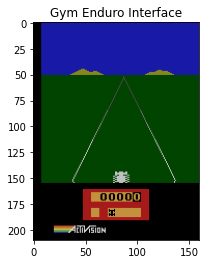

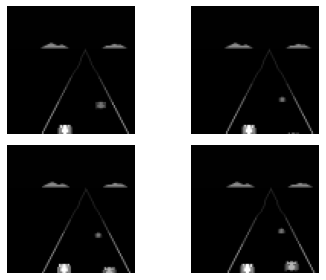

obs shape: (4, 84, 84)
actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE'] amount: 9


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4) # saltamos de a 4 frames para acelerar entrenamiento

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env) # pasamos el wrapper al enviroment
env = FrameStack(env,num_stack=4) # un estado definido como el actual mas los 3 anteriores
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print("obs shape:", obs.shape)
print("actions:", env.get_action_meanings(), "amount:", env.action_space.n)

### Actividad 1
Definimos un estado como un stack de el frame actual, más los 3 frames anteriores, por lo que cada estado (que será el input de la red) corresponde a 4 pasos de Enduro. Esto es clave para que la red convolucional pueda tener una noción de velocidad del jugador y de los demás competidores. La velocidad solo puede obtenerse comparando posiciones en frames contiguas, lo cual es información indispensable para que un agente pueda aprender a jugar Enduro competentemente.

### Fill replay memory

In [7]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list
        self.next_replace_position = 0

    def push(self, state, action, next_state, reward, done):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """
        memory_data = (state, action, next_state, reward, done)
        if len(self) >= self.capacity:
          self.memory[self.next_replace_position] = memory_data
          self.next_replace_position += 1
          if self.next_replace_position > self.capacity - 1:
            self.next_replace_position = 0
        else:
          self.memory.append(memory_data)

    def sample(self, batch_size):
       """ Samples a transition with a defined batch size"""
       sampled_tuples = random.sample(self.memory, batch_size) # list of tuples
       zipped = tuple(zip(*sampled_tuples))
       return zipped
      
    def __len__(self):
        return len(self.memory)

In [8]:
memory_size = 500000
replay_memory = ReplayMemory(memory_size)
loaded_model = False

print("Filling random Replay Memory...")
current_obs = env.reset()
for _ in range(memory_size):
  if _ % 100000 == 0:
    print(f"{_}/{memory_size}")
  action = random.randint(0, env.action_space.n-1) # seleccionar accion random
  obs, reward, done, info = env.step(action)
  replay_memory.push(current_obs, action, obs, reward, done)
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()

print("Random Replay Memory Filled!, Resources:")
printm()

Filling random Replay Memory...
0/500000
100000/500000
200000/500000
300000/500000
400000/500000
Random Replay Memory Filled!, Resources:
RAM Free: 8.3 GB  | Used: 4.6 GB
VRAM Free: 15109MB | Used: 0MB | Util   0% Total 15109MB


##Model

In [9]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)

        self.relu = nn.ReLU()

    def forward(self, x):
      # X es un tensor (batch_size x 4 x 84 x 84) que representa un batch de stacks de estados
      batch_size = x.size(0)

      # forward pass red convolucional
      x = self.relu(self.conv1(x))
      x = self.relu(self.conv2(x))
      x = self.relu(self.conv3(x))
      x = torch.flatten(x, start_dim=1) # start_dim 1 para mantener separado el batch
      #print("State embedding:", x.shape, x)
      
      # forward pass rama fully-connected para V(s)
      v_s = self.relu(self.fc1_val(x))
      v_s = self.fc2_val(v_s).expand(batch_size, self.num_actions)
      #print("V(s):", v_s.shape, v_s)

      # forward pass rama fully-connected para A(s,a)
      adv = self.relu(self.fc1_adv(x))
      adv = self.fc2_adv(adv)
      #print("A(s,a):", adv.shape, adv)
      #print("mean A(s,a):", torch.mean(adv, 1, keepdim=True).shape, torch.mean(adv, 1, keepdim=True))

      # Calculo de Q(s,a) a partir de ecuacion (4)
      Q_values = v_s + (adv - torch.mean(adv, 1, keepdim=True)) # testeado

      return Q_values # batch_size x num_actions

##Training

In [10]:
def exploration(total_steps):
  """ retorna probabilidad de que explore con accion random """
  if total_steps >= 1000000:
    epsilon = 0.1
  else:
    m = -0.9 / 1000000
    n = 1
    epsilon = m * total_steps + n
  return epsilon

In [11]:
# Define parameters and instance NNs

from torch import device
import torch.optim as optim
import torch.nn as nn

device = device('cuda' if torch.cuda.is_available() else 'cpu')

frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
batch_size = 32
gamma = 0.99 # Factor de descuento
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se modifican los pesos (loss backprop) en la red Q
target_update_freq = 10000 # Frecuencia en que se actualizan los pesos de la red target Q' (cada x backprops, updateo Q')
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device) # esta es la que de verdad quiero entrenar
Q_target = Dueling_DQN(in_channels, num_actions).to(device) # para estabilidad, esta me entrega los labels

# Optimizador, pueden elegir entre Adam o RMSProp
optimizer = optim.Adam(Q.parameters(), lr=LR)

LOG_EVERY_N_STEPS = 50000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250000 # Pasos por época
N_EPOCHS = 10 # Número de épocas

In [ ]:
# Run only if continuing training of existing model

import torch
import numpy as np

# load state dict and pass it to Q and Q_target
model_save_path = my_dir + "/DQN_model_X.pt
Q.load_state_dict(torch.load(model_save_path, map_location=device))
Q_target.load_state_dict(torch.load(model_save_path, map_location=device)))
optimizer = optim.Adam(Q.parameters(), lr=LR)
loaded = True

memory_size = 500000
replay_memory = ReplayMemory(memory_size)

print("Filling Replay Memory with pretrained DQN...")
current_obs = env.reset()
for _ in range(memory_size):
  if _ % 100000 == 0:
    print(f"{_}/{memory_size}")
    with torch.no_grad(): # no actualizamos gradientes pq estamos evaluando
      # Seleccionar la acción segun la red Q
      last_obs_tensor = torch.from_numpy(np.array(current_obs)).to(device) / 255.0 # pasamos a tensor y normalizamos
      last_obs_tensor_batched = last_obs_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1) # last obs solo es 1 estado, pero necesitamos batch_size estados para la red
      all_q_values = Q(last_obs_tensor_batched)
      action = ((all_q_values).data.max(1)[1])[0].item() # selecciono indice de mejor q_value
  obs, reward, done, info = env.step(action)
  replay_memory.push(current_obs, action, obs, reward, done)
  current_obs = obs
  if done: # si pierde partimos nuevo episodio
    current_obs = env.reset()

print("Pretrained Replay Memory Filled!, Resources:")
printm()

In [ ]:
import json

a_file = open(my_dir + "/rewards.json", "r")
reward_history = json.loads(a_file.read())
a_file.close()
print(reward_history)

In [ ]:
from tqdm import tqdm
import torch
import numpy as np
import json

if not loaded:
  reward_history = {} # epoch: mean reward of last 100 episodes
  error_history = {} # epoch: mean error
else:
  a_file = open(my_dir + "/rewards.json", "r")
  reward_history = json.loads(a_file.read())
  a_file.close()

  b_file = open(my_dir + "/errors.json", "r")
  error_history = json.loads(b_file.read())
  b_file.close()

last_obs = env.reset() # Reseteamos nuestro ambiente para empezar el entrenamiento
current_reward = 0
backprops = 0
episodes_rewards = []
errors = []

for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
    total_steps = t + STEPS_PER_EPOCH * epoch # steps acumulados a traves de las epocas
    ### 1. Choose actions and update replay memory buffer
    if t < learning_starts and epoch == 0:
      action = np.random.randint(num_actions)
    else:
      # epsilon greedy exploration
      sample = random.random()
      threshold = exploration(total_steps)  # la funcion exploration permite calcular el threshold para la política e-greedy
      if sample <= threshold:
        action = np.random.randint(num_actions)
      else:
        with torch.no_grad(): # no actualizamos gradientes pq estamos evaluando
          # Seleccionar la acción segun la red Q
          last_obs_tensor = torch.from_numpy(np.array(last_obs)).to(device) / 255.0 # pasamos a tensor y normalizamos
          last_obs_tensor_batched = last_obs_tensor.unsqueeze(0).repeat(batch_size, 1, 1, 1) # last obs solo es 1 estado, pero necesitamos batch_size estados para la red
          all_q_values = Q(last_obs_tensor_batched)
          action = ((all_q_values).data.max(1)[1])[0].item() # selecciono indice de mejor q_value

    obs, reward, done, _ = env.step(action) # ejecuto accion seleccionada
    replay_memory.push(last_obs, action, obs, reward, done) # actualizo experiencia en buffer
    current_reward += reward
    if done:
      # Termino episodio!
      obs = env.reset()
      # Guardar reward acumulado del episodio
      episodes_rewards.append(current_reward)
      current_reward = 0

    # update last_obs
    last_obs = obs

    ### 2. Perform experience replay and train the network.
    if (t > learning_starts and t % learning_freq == 0):
      obs_t, act_t, next_obs, rew_t, done_mask = replay_memory.sample(batch_size) # esto me deja listas de largo batch size
      # Pasar los arreglos a tensores y al device actual
      obs_t = torch.from_numpy(np.array(obs_t)).to(device)
      act_t = torch.from_numpy(np.array(act_t)).to(device)
      next_obs = torch.from_numpy(np.array(next_obs)).to(device)
      rew_t = torch.from_numpy(np.array(rew_t)).to(device)
      done_mask = torch.from_numpy(np.array(done_mask)).to(device)

      # Normalizar tensores de entrada
      obs_t = obs_t / 255.0
      next_obs = next_obs / 255.0

      # construir Y (labels)
      with torch.no_grad(): # esto no debe ser parte del backprop, solo consigue los labels
        q_tp1_values = Q(next_obs)
        _, a_prime = q_tp1_values.max(1) # selecciono la mejor accion para el estado siguiente
        q_target_tp1_values = Q_target(next_obs)
        q_target_s_a_prime = q_target_tp1_values.gather(1, a_prime.unsqueeze(1)).squeeze() # selecciono el q_value de la target network segun la mejor accion en el estado siguiente
        # si termina en este episodio, los q_values de target son 0 y dejamos solo el reward
        q_target_s_a_prime = (1 - done_mask.type(torch.float)) * q_target_s_a_prime 
        
        y = rew_t + gamma * q_target_s_a_prime

      ## Loss calculation
      q_values = Q(obs_t)
      q_s_a = q_values.gather(1, act_t.unsqueeze(1)).squeeze() # selecciono el q de cada accion
      error = (y - q_s_a) ** 2
      error = torch.mean(error.clamp(0, 1)) # clipeamos para estabilidad
      errors.append(error.item())

      # backwards pass
      optimizer.zero_grad()
      error.backward()

      # update
      optimizer.step()
      backprops += 1

      # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)
      if backprops % target_update_freq == 0:
        print("Copying model wieghts...")
        Q_target.load_state_dict(Q.state_dict()) # copiamos pesos de Q a Qtarget
    
    if t % LOG_EVERY_N_STEPS == 0:
      print("\nEpoch:", epoch + 1)
      print("Current steps:", t, "Total Steps:", total_steps)
      print("Reward avg:", np.mean(episodes_rewards[-100:]))
      print("Error avg:", np.mean(errors[-100:]))
      printm()

  # Epoch ends, save model and results
  model_save_path = my_dir + "/DQN_model_{}.pt".format(epoch)
  torch.save(Q.state_dict(), model_save_path)

  reward_history[epoch] = np.mean(episodes_rewards[-100:])
  error_history[epoch] = np.mean(errors[-100:])

  a_file = open(my_dir + "/rewards.json", "w")
  json.dump(reward_history, a_file)
  a_file.close()

  b_file = open(my_dir + "/errors.json", "w")
  json.dump(reward_history, b_file)
  b_file.close()

  episodes_rewards = [] # reset
  errors = [] # reset
  print("Model and data saved!")

## Results

###Testing visualization

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames[:300]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())